##Imports

In [ ]:
#imports
from skimage.data import brain
import matplotlib.pyplot as plt
import numpy as np
from IPython.display import display, clear_output
from skimage.data import brain
from skimage.transform import resize,rescale
from skimage.metrics import mean_squared_error, structural_similarity

##Load true image

In [ ]:
plt.ion()
brainimage = brain()

# Dimensions of image
nxd = 128

true_object_np = resize(brainimage[9, 30: -1, : -30], (nxd, nxd), anti_aliasing=False)


##Define functions

In [ ]:
# Number of viewing angles in the sinogram
nphi = int(nxd * 1.42)

# Number of pixels in the radial dimension
nrd = int(nxd * 1.42)

# System matrix as a numpy array
def make_numpy_system_matrix(nxd, nrd, nphi):
    system_matrix = np.zeros((nrd * nphi, nxd * nxd))  # Rows = num of sinogram bins, Cols = num of image pixels
    for xv in range(nxd):
        for yv in range(nxd):   # select pixel with coordinates (xv, yv)
            for ph in range(nphi):  # For each angle, the pixel is projected
                yp = -(xv - (nxd * 0.5)) * np.sin(ph * np.pi / nphi) + (yv - (nxd * 0.5)) * np.cos(ph * np.pi / nphi)
                yp_bin = int(yp + nrd / 2.0)  # We find where each pixel lands on the sinogram and build the system matrix
                system_matrix[yp_bin + ph * nrd, xv + yv * nxd] = 1.0
    return system_matrix

# Forward project the image using the system matrix
def fp_system_numpy(image, sys_mat, nxd, nrd, nphi):
    return np.reshape(np.dot(sys_mat, np.reshape(image, (nxd * nxd, 1))), (nphi, nrd))

# Back project the sinogram to obtain an image
def bp_system_numpy(sino, sys_mat, nxd, nrd, nphi):
    return np.reshape(np.dot(sys_mat.T, np.reshape(sino, (nrd * nphi, 1))), (nxd, nxd))

##Obtain true sinogram

In [ ]:
sys_mat_np = make_numpy_system_matrix(nxd, nrd, nphi)
true_sinogram = fp_system_numpy(true_object_np, sys_mat_np, nxd, nrd, nphi)

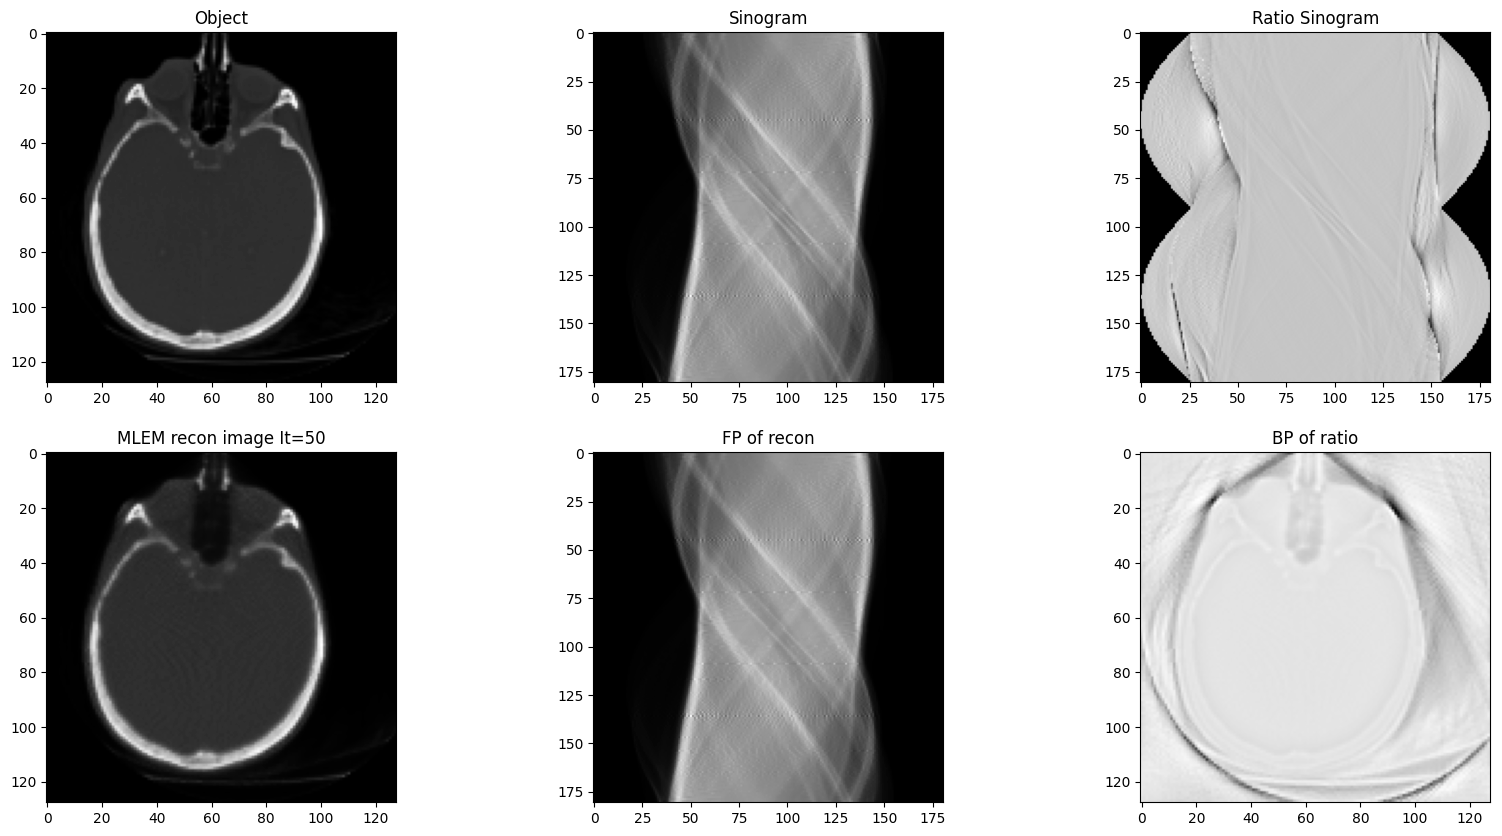

In [ ]:
plt.ion()
brainimage = brain()
true_object = resize(brainimage[9, 30: -1, : -30], (128, 128), anti_aliasing=False)


fig, axs = plt.subplots(2, 3, figsize=(20, 10))
axs[0, 0].imshow(true_object, cmap='Greys_r')
axs[0, 0].set_title('Object')

azi_angles = np.linspace(0.0, 180.0, 180, endpoint=False) # Viewing angles

# Generating the simulated sinogram using forward projection
axs[0, 1].imshow(true_sinogram, cmap='Greys_r')
axs[0, 1].set_title('Sinogram')

mlem_rec = np.ones(true_object.shape) # Iteration 0, Xk for k=0
sino_ones = np.ones(true_sinogram.shape)
sens_image = bp_system_numpy(sino_ones,sys_mat_np, nxd,nrd,nphi)

# Lists to store performance metrics
mse_values = []
ssim_values = []
cc_values = []
mae_values = []

for iter in range(50):
    fp = fp_system_numpy(mlem_rec, sys_mat_np, nxd, nrd, nphi)
    ratio = true_sinogram / (fp + 0.000001)

    # Correction step
    correction  = bp_system_numpy(ratio, sys_mat_np, nxd, nrd, nphi) / sens_image

    axs[1, 0].imshow(mlem_rec, cmap='Greys_r')
    axs[1, 0].set_title('MLEM reconstruction')

    axs[1, 1].imshow(fp, cmap='Greys_r')
    axs[1, 1].set_title('FP of recon')

    axs[0, 2].imshow(ratio, cmap='Greys_r')
    axs[0, 2].set_title('Ratio Sinogram')

    axs[1, 2].imshow(correction, cmap='Greys_r')
    axs[1, 2].set_title('BP of ratio')

    # Update reconstruction
    mlem_rec = mlem_rec * correction

    axs[1, 0].imshow(mlem_rec, cmap='Greys_r')
    axs[1, 0].set_title('MLEM recon image It=%d' % (iter + 1))
    display(fig)


    mse = mean_squared_error(true_object, mlem_rec)
    mae = np.mean(np.abs(true_object - mlem_rec))
    ssim = structural_similarity(true_object, mlem_rec)
    cc = np.corrcoef(true_object.ravel(), mlem_rec.ravel())[0, 1]

    mse_values.append(mse)
    ssim_values.append(ssim)
    cc_values.append(cc)
    mae_values.append(mae)

    clear_output(wait=True)
    plt.pause(0.5)




In [ ]:
# Plot MSE, SSIM, CC over iterations
plt.figure(figsize=(10, 5))
plt.plot(range(1, 51), mse_values, label='MSE', marker='')
plt.plot(range(1, 51), ssim_values, label='SSIM', marker='')
plt.plot(range(1, 51), cc_values, label='CC', marker='')
plt.plot(range(1, 51), mae_values, label='MAE', marker='')

plt.xlabel('Iteration')
plt.ylabel('Value')
plt.title('Performance Metrics over Iterations')
plt.legend()
plt.grid(True)
plt.show(block=True)


In [ ]:
import csv

# Define file name
file_name = "performance_metrics.csv"

# Write the values to the CSV file
with open('performance_metrics.csv', mode='w', newline='') as file:
    writer = csv.writer(file)
    writer.writerow(["Iteration", "MSE", "SSIM", "CC", "MAE"])
    for i in range(len(mse_values)):
        writer.writerow([i+1, mse_values[i], ssim_values[i], cc_values[i], mae_values[i]])

print("Values saved to", file_name)


Values saved to performance_metrics.csv
